In [1]:
import subprocess
import csv

import numpy as np
import matplotlib.pyplot as plt

import ipywebrtc
import pydub

In [17]:
average_male_ipa = [
    ["i", 240, 2400],
    ["y", 235, 2100],
    ["e", 390, 2300],
    ["ø", 370, 1900],
    ["ɛ", 610, 1900],
    ["œ", 585, 1710],
    ["a", 850, 1610],
    ["ɶ", 820, 1530],
    ["ɑ", 750, 940],
    ["ɒ", 700, 760],
    ["ʌ", 600, 1170],
    ["ɔ", 500, 700],
    ["ɤ", 460, 1310],
    ["o", 360, 640],
    ["ɯ", 300, 1390],
    ["u", 250, 595],
]

In [2]:
def number(x):
    try:
        return float(x)
    except ValueError:
        return float("nan")

In [25]:
def plot(recorder, alphabet, tmp_filename="/tmp/praat-formants-sample"):
    recorder.save(tmp_filename + ".webm")

    webm = pydub.AudioSegment.from_file(tmp_filename + ".webm")
    webm.export(tmp_filename + ".wav", format="wav")

    formants = np.array(
        [
            list(map(number, x))
            for x in csv.reader(
                subprocess.run(
                    [
                        "praat_nogui", "--run", "formants.praat", tmp_filename + ".wav", "5500", "0.025", "50"
                    ],
                    stdout=subprocess.PIPE,
                )
                .stdout.decode()
                .strip()
                .split("\n"),
                delimiter="\t",
            )
        ][1:]
    )
    intensity = np.array(
        [
            list(map(number, x))
            for x in csv.reader(
                subprocess.run(
                    [
                        "praat_nogui", "--run", "intensity.praat", tmp_filename + ".wav"
                    ],
                    stdout=subprocess.PIPE,
                )
                .stdout.decode()
                .strip()
                .split("\n"),
                delimiter=" ",
            )
        ]
    )
    assert np.max(formants[:, 0] - intensity[2:-2, 0]) < 0.004

    no_nan = ~(np.isnan(formants[:, 1]) | np.isnan(formants[:, 2]) | np.isnan(intensity[2:-2, 1]))
    weights = (intensity[2:-2, 1] - np.nanmin(intensity[2:-2, 1]))[no_nan]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.hist2d(
        x=formants[no_nan, 1],
        y=formants[no_nan, 2],
        weights=weights,
        bins=(100, 100),
        range=((100, 1000), (250, 2750)),
        density=True,
        vmin=1e-5,
        vmax=1e-4,
        cmap="Oranges",
    );
    for vowel, x, y in alphabet:
        ax.text(x, y, vowel, va="center", ha="center", fontsize="xx-large", c="blue");
    ax.set_xlabel("$F_1$ (Hz)");
    ax.set_ylabel("$F_2$ (Hz)");

In [27]:
camera = ipywebrtc.CameraStream(constraints={"audio": True, "video": False})
recorder = ipywebrtc.AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

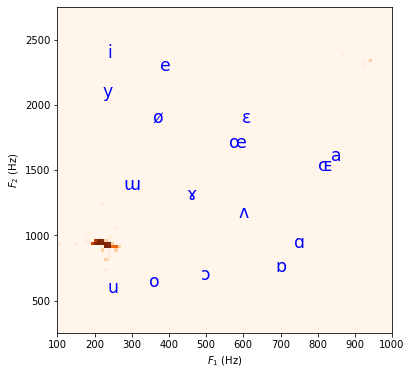

In [28]:
plot(recorder, average_male_ipa)